In [1]:
import ipynb_importer
import easy_util
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers.merge import Add

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

importing Jupyter notebook from easy_util.ipynb


Using TensorFlow backend.
D:\Users\wat\Anaconda2\envs\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
image_size = 64                # 用于训练的图片大小
train_size = None               # 训练集大小，从原训练集中取前train_size个样本
test_size = None                # 测试集大小
epochs = [20,5,5]                     # 训练轮数
learning_rate = [0.001,0.0001,0.00001]        # 学习率
batch_size = 16                # 训练时每个batch包含的样本数
loss = 'binary_crossentropy'   # 损失函数，同keras中model.fit的同名参数
n_folds = 5                    # 进行几折交叉校验(cross validation)
threshold = 0.2                # 预测值大于threshold被视为包含该标签
metrics = ['accuracy', easy_util.F2_score(threshold=threshold)] # 评估函数，同keras中model.fit的同名参数

datapath = '../dataset/'       # 数据集所在的文件夹路径
weights_path = '../models/'    # 保存模型权重的路径
output_path = '../output/'     # 结果文件的写出路径
output_file_name = 'resnet_plus.csv'  # 结果文件名字

In [3]:
x_train, y_train, x_test, labels, df_test = easy_util.get_model_input(datapath=datapath,image_size=image_size, \
                                                                      train_size=train_size, test_size=test_size)

100%|█████████████████████████████████████████| 61191/61191 [13:54<00:00, 73.30it/s]


In [4]:
def identity_mapping_block(pre_layer=None,depth=32):
    conv_1 = Conv2D(depth, kernel_size=(3, 3),padding='same')(pre_layer)
    norm_1 = BatchNormalization()(conv_1)
    actv_1 = Activation(activation='relu')(norm_1)
    conv_2 = Conv2D(depth, kernel_size=(3, 3),padding='same')(actv_1)
    norm_2 = BatchNormalization()(conv_2)
    add = Add()([pre_layer, norm_2])
    actv = Activation(activation='relu')(add)
    return actv

In [5]:
def transform_mapping_block(pre_layer=None, output_depth=64):
    pool = MaxPooling2D(pool_size=(2, 2))(pre_layer)
    bottleneck = Conv2D(output_depth, kernel_size=(1, 1),padding='same', activation='relu')(pool)
    conv_1 = Conv2D(output_depth, kernel_size=(3, 3),padding='same')(pool)
    norm_1 = BatchNormalization()(conv_1)
    actv_1 = Activation(activation='relu')(norm_1)
    conv_2 = Conv2D(output_depth, kernel_size=(3, 3),padding='same')(actv_1)
    norm_2 = BatchNormalization()(conv_2)
    add = Add()([bottleneck, norm_2])
    actv = Activation(activation='relu')(add)
    return actv

In [6]:
input = Input(shape=(image_size, image_size,3))
conv = Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu')(input)
norm = BatchNormalization()(conv)
out = identity_mapping_block(norm, 32)
out = identity_mapping_block(out, 32)
out = Dropout(0.25)(out)
out = transform_mapping_block(out, 64)
out = identity_mapping_block(out, 64)
out = Dropout(0.25)(out)
out = transform_mapping_block(out, 128)
out = identity_mapping_block(out, 128)
out = Dropout(0.25)(out)
out = transform_mapping_block(out, 256)
out = identity_mapping_block(out, 256)
out = MaxPooling2D(pool_size=(2, 2))(out)
out = Dropout(0.25)(out)
flatten = Flatten()(out)
dense256 = Dense(512, activation='relu')(flatten)
drop = Dropout(0.5)(dense256)
dense17 = Dense(17, activation='sigmoid')(drop)

model = Model(inputs=[input], outputs=[dense17])

In [7]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 64, 32)    896         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 64, 64, 32)    128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 64, 64, 32)    9248        batch_normalization_1[0][0]      
___________________________________________________________________________________________

batch_normalization_10 (BatchNor (None, 16, 16, 128)   512         conv2d_12[0][0]                  
____________________________________________________________________________________________________
activation_9 (Activation)        (None, 16, 16, 128)   0           batch_normalization_10[0][0]     
____________________________________________________________________________________________________
conv2d_13 (Conv2D)               (None, 16, 16, 128)   147584      activation_9[0][0]               
____________________________________________________________________________________________________
conv2d_11 (Conv2D)               (None, 16, 16, 128)   8320        max_pooling2d_2[0][0]            
____________________________________________________________________________________________________
batch_normalization_11 (BatchNor (None, 16, 16, 128)   512         conv2d_13[0][0]                  
___________________________________________________________________________________________

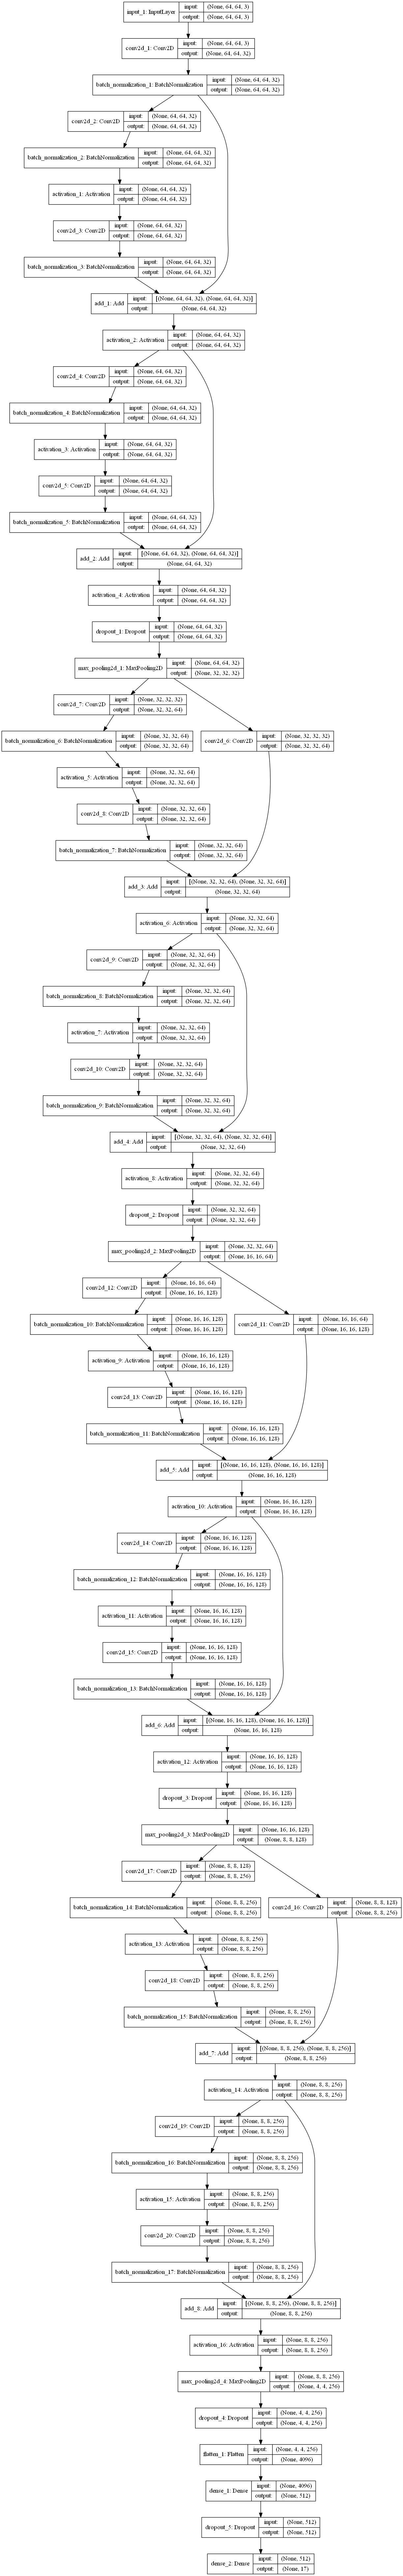

In [12]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file='../models/resnet/model2.jpg',show_shapes=True)
Image(filename='../models/resnet/model2.jpg', width=500, height=800) 

In [8]:
history, result = easy_util.run_model(metrics=metrics, model=model, x_train=x_train, nfolds=n_folds, weights_path=weights_path, \
                         y_train=y_train, x_test=x_test, batch_size=batch_size, loss=loss, \
                         labels=labels, learning_rate_list=[0.001,0.0001,0.00001], epochs_list=[20,5,5])

Start KFold number 1 from 5
Split train:  32383 32383
Split valid:  8096 8096
Train on 32383 samples, validate on 8096 samples
Epoch 1/20
668s - loss: 0.3289 - acc: 0.9099 - FScore2: 0.7391 - val_loss: 0.5166 - val_acc: 0.9095 - val_FScore2: 0.6741
Epoch 2/20
650s - loss: 0.1909 - acc: 0.9252 - FScore2: 0.8120 - val_loss: 0.3008 - val_acc: 0.9130 - val_FScore2: 0.7198
Epoch 3/20
650s - loss: 0.1702 - acc: 0.9329 - FScore2: 0.8369 - val_loss: 0.2507 - val_acc: 0.9175 - val_FScore2: 0.7319
Epoch 4/20
646s - loss: 0.1594 - acc: 0.9363 - FScore2: 0.8520 - val_loss: 0.2759 - val_acc: 0.9145 - val_FScore2: 0.7213
Epoch 5/20
650s - loss: 0.1487 - acc: 0.9403 - FScore2: 0.8628 - val_loss: 0.2330 - val_acc: 0.9153 - val_FScore2: 0.7802
Epoch 6/20
650s - loss: 0.1406 - acc: 0.9441 - FScore2: 0.8723 - val_loss: 0.2076 - val_acc: 0.9286 - val_FScore2: 0.8011
Epoch 7/20
646s - loss: 0.1362 - acc: 0.9456 - FScore2: 0.8770 - val_loss: 0.2485 - val_acc: 0.9159 - val_FScore2: 0.7549
Epoch 8/20
646s - l

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'g')
plt.legend(('training_loss', 'testing_loss'))

In [ ]:
easy_util.write_output(result=result, df_test=df_test, output_path=output_path, file_name=output_file_name, threshold=threshold)